In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
import codecs
from hazm import Normalizer
import ast
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

## Label Sample

In [2]:
dmd_label = {
     'DMD-30': 'Chemical'
    ,'DMD-62':'Electrical'
    ,'DMD-81' : 'Agricultural'
    ,'DMD-111': 'Medical'
    ,'DMD-158': 'Medical'
    ,'DMD-164': 'Medical'
    ,'DMD-181': 'Chemical'
    ,'DMD-182' : 'Chemical'
    ,'DMD-229': 'Chemical'
    ,'DMD-230': 'Chemical'
    ,'DMD-248' : 'Chemical'
    ,'DMD-255': 'Agricultural'
    ,'DMD-258' : 'Agricultural'
    ,'DMD-289' : 'Electrical'
    ,'DMD-318' : 'Chemical'
    ,'DMD-432' : 'Chemical'
    ,'DMD-444' : 'Chemical'
    ,'DMD-463':  'Chemical'
    ,'DMD-490' : 'Medical'
    ,'DMD-494' : 'Chemical'
    ,'DMD-529' : 'Chemical'
    ,'DMD-537' : 'Agricultural'
    ,'DMD-582': 'Chemical'
    ,'DMD-588': 'Electrical'
    ,'DMD-670': 'Chemical'
    ,'DMD-689': 'Chemical'
    ,'DMD-694': 'Chemical'
    ,'DMD-699': 'Electrical'
    ,'DMD-706': 'Chemical'
    ,'DMD-721': 'Chemical'
    ,'DMD-726': 'Chemical'
    ,'DMD-860': 'Chemical'
    ,'DMD-880': 'Chemical'
    ,'DMD-906': 'Medical'
    ,'DMD-927': 'Chemical'
    ,'DMD-955': 'Medical'
    ,'DMD-958': 'Chemical'
    ,'DMD-959' : 'Electrical'
    ,'DMD-970': 'Electrical'
    ,'DMD-979': 'Chemical'
    ,'DMD-1054': 'Electrical'
    ,'DMD-1131': 'Chemical'
    ,'DMD-1170': 'Chemical'
    ,'DMD-1186':'Chemical'
    ,'DMD-1187':'Chemical'
    ,'DMD-1201': 'Chemical'
    ,'DMD-1203':'Chemical'
    ,'DMD-1342': 'Electrical'
    ,'DMD-1388': 'Electrical'
    ,'DMD-1391': 'Chemical'       
}

In [3]:
prd_label = {
     'PRD-203':'Electrical'
    ,'PRD-283': 'Medical'
    ,'PRD-486': 'Electrical'
    ,'PRD-913':'Chemical'
    ,'PRD-950': 'Medical'
    ,'PRD-977': 'Chemical'
    ,'PRD-1471' :  'Electrical'
    ,'PRD-1750': 'Medical'
    ,'PRD-2205': 'Chemical'
    ,'PRD-2901': 'Chemical'
    ,'PRD-2967' : 'Agricultural'
    ,'PRD-3517': 'Chemical'
    ,'PRD-3948': 'Chemical'
    ,'PRD-4086':  'Electrical'
    ,'PRD-4121': 'Agricultural'
    ,'PRD-5099': 'Chemical'
    ,'PRD-5103': 'Chemical'
    ,'PRD-5679': 'Agricultural'
    ,'PRD-5702': 'Chemical'
    ,'PRD-6025': 'Electrical'
    ,'PRD-6170': 'Chemical'
    ,'PRD-6766': 'Chemical'
    ,'PRD-6860': 'Agricultural'
    ,'PRD-6961': 'Electrical'
    ,'PRD-7486': 'Chemical'
    ,'PRD-8144': 'Electrical'
    ,'PRD-8591': 'Electrical'
    ,'PRD-8827':'Agricultural'
    ,'PRD-9495': 'Agricultural'
    ,'PRD-9672': 'Chemical'
    ,'PRD-9940': 'Agricultural'
    ,'PRD-10940': 'Chemical'
    ,'PRD-11356' : 'Chemical'
    ,'PRD-11884':'Chemical'
    ,'PRD-12034':'Chemical'
    ,'PRD-12266' : 'Chemical'
    ,'PRD-12503': 'Medical'
    ,'PRD-12701': 'Medical'
    ,'PRD-12985': 'Medical'
    ,'PRD-13101': 'Electrical'
    ,'PRD-13735':'Electrical'
    ,'PRD-14195':'Chemical'
    ,'PRD-14657':'Electrical'
    ,'PRD-14895': 'Chemical'
    ,'PRD-15144':'Chemical'
    ,'PRD-15227': 'Chemical'
    ,'PRD-15671': 'Chemical'
    ,'PRD-15942': 'Medical'
    ,'PRD-15943': 'Medical'
    ,'PRD-16014': 'Electrical'

}

In [4]:
tokenized_dmd_df = pd.read_csv('D:/Military/Tokenize/tokenized_dmd_df.csv', converters={'tokenized_dmd_title': ast.literal_eval, 'tokenized_dmd_description': ast.literal_eval, 'tokenized_dmd_key_words': ast.literal_eval}).sort_values('dmd_urlIdentifier')
tokenized_prd_df = pd.read_csv('D:/Military/Tokenize/tokenized_prd_df.csv', converters={'tokenized_prd_title': ast.literal_eval, 'tokenized_prd_description': ast.literal_eval, 'tokenized_prd_key_words': ast.literal_eval}).sort_values('prd_urlIdentifier')
tokenized_dmd_sample = tokenized_dmd_df[tokenized_dmd_df['dmd_urlIdentifier'].isin(list(dmd_label.keys()))].sample(n=30,random_state= 1234).sort_values('dmd_urlIdentifier')
tokenized_prd_sample = tokenized_prd_df[tokenized_prd_df['prd_urlIdentifier'].isin(list(prd_label.keys()))].sample(n=30,random_state= 1234).sort_values('prd_urlIdentifier')

In [5]:
tokenized_dmd_sample['dmd_label'] = tokenized_dmd_sample.apply(lambda x: dmd_label[x['dmd_urlIdentifier']],axis=1)
tokenized_prd_sample['prd_label'] = tokenized_prd_sample.apply(lambda x: prd_label[x['prd_urlIdentifier']],axis=1)

In [6]:
print("dmd sample size: ",tokenized_dmd_sample.shape[0])
print("prd sample size: ",tokenized_prd_sample.shape[0])

dmd sample size:  30
prd sample size:  30


In [14]:
tokenized_dmd_sample[['dmd_title','dmd_urlIdentifier','dmd_key_words','dmd_description','dmd_label']].head(30)
tokenized_dmd_sample[['dmd_title','dmd_urlIdentifier','dmd_key_words','dmd_description','dmd_label']].head(30).to_excel('dmd.xlsx')

In [13]:
tokenized_prd_sample[['prd_title','prd_urlIdentifier','prd_key_words','prd_description','prd_label']].head(30)
tokenized_prd_sample[['prd_title','prd_urlIdentifier','prd_key_words','prd_description','prd_label']].head(30).to_excel('prd_sample.xlsx')

# Cosine Similarity

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
def convert_value(x):
    if x >= 0.1:
        return 1
    else:
        return 0

In [13]:
most_similar_result = None
most_similar_label  = None
for c in ['title','description','key_words']:
    dmd_token = [' '.join(tokens) for tokens in tokenized_dmd_sample['tokenized_dmd_' + str(c)]]
    prd_token = [' '.join(tokens) for tokens in tokenized_prd_sample['tokenized_prd_' + str(c)]]

    tfidf_vectorizer = TfidfVectorizer()

    all_token = dmd_token + prd_token

    tfidf_matrix = tfidf_vectorizer.fit_transform(all_token)

    similarity_matrix = cosine_similarity(tfidf_matrix[:len(dmd_token)], tfidf_matrix[len(dmd_token):])   
    matching_results = pd.DataFrame(similarity_matrix,index= tokenized_dmd_sample[['dmd_label','dmd_urlIdentifier']],columns = tokenized_prd_sample[['prd_label','prd_urlIdentifier']])
    matching_label = pd.DataFrame(similarity_matrix,index= tokenized_dmd_sample['dmd_label'],columns = tokenized_prd_sample['prd_label']).applymap(lambda x:convert_value(x))
    
    if most_similar_result is None:
        most_similar_result = matching_results
    else:
        most_similar_result = pd.concat([most_similar_result, matching_results]).groupby(level=0).max()

    if most_similar_label is None:
        most_similar_label = matching_label
    else:
        most_similar_label = pd.concat([most_similar_label, matching_label]).groupby(level=0).max()


Text(158.22222222222223, 0.5, 'Demand (ID,Label)')

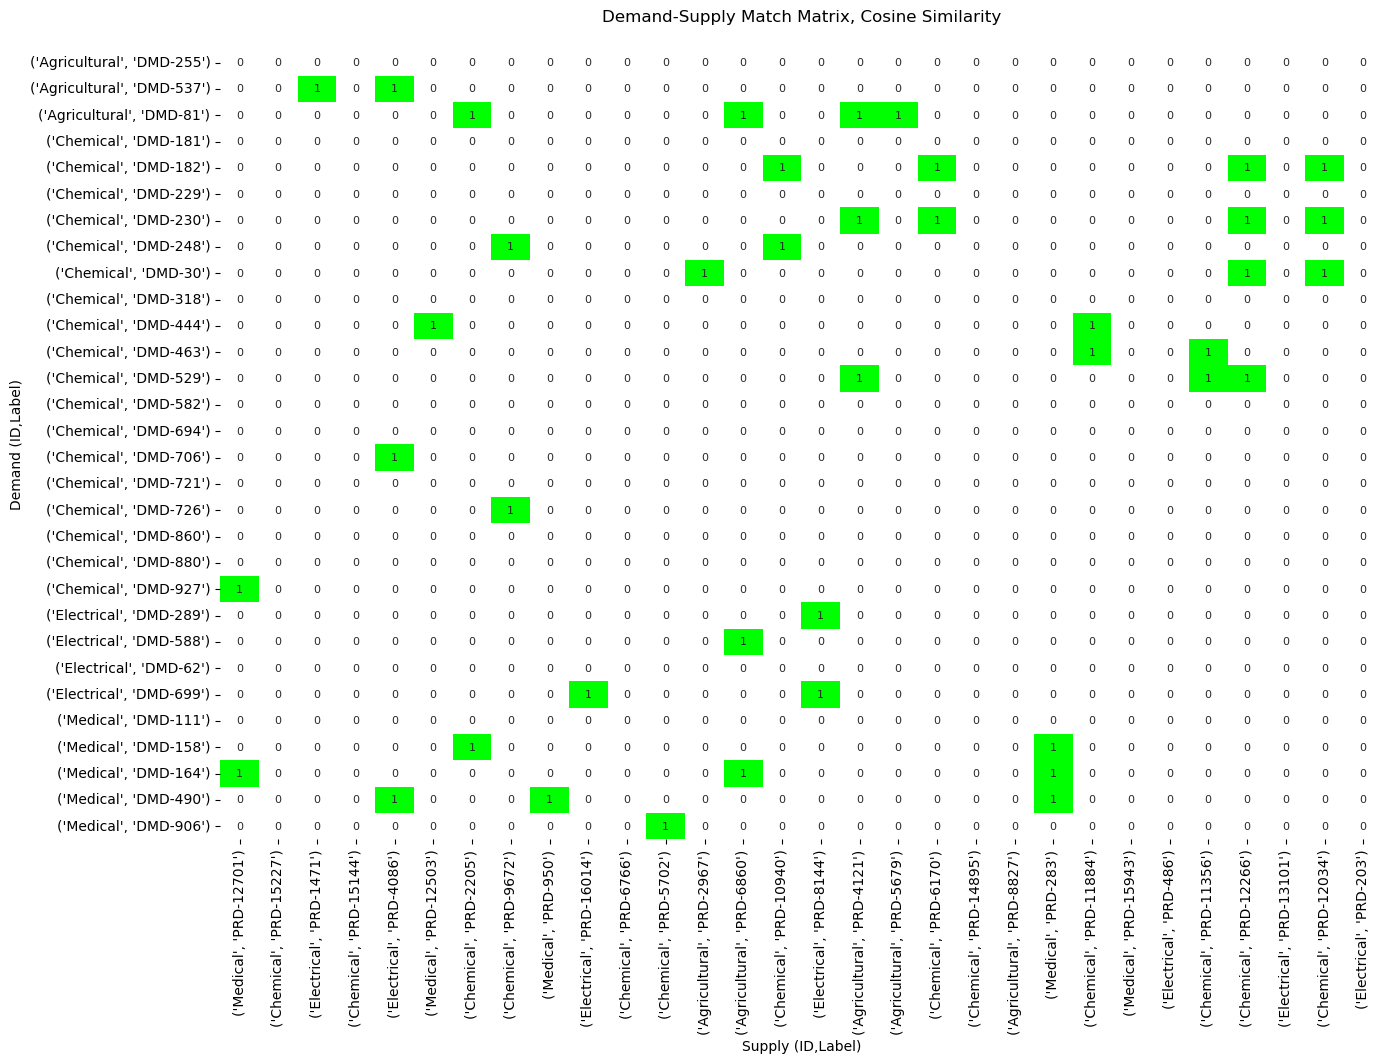

In [14]:
# plot 
plt.figure(figsize=(15,10))
plt.subplots_adjust(top=0.9)  # Adjust top margin
plt.subplots_adjust(right=0.9)
colors = [(1, 1, 1), (0, 1, 0)]  # Define white to green
cmap = mcolors.LinearSegmentedColormap.from_list("my_white_green_colormap", colors)
sns.heatmap(most_similar_result.applymap(lambda x: convert_value(x)), annot=True, fmt="d", cmap=cmap, annot_kws={"size": 8},cbar=False)
plt.title('Demand-Supply Match Matrix, Cosine Similarity', pad=20)
plt.xlabel('Supply (ID,Label)')
plt.ylabel('Demand (ID,Label)')

In [15]:
from tabulate import tabulate
aggrgated_matching_label= matching_label.groupby(matching_label.index).sum().T.groupby(matching_label.columns).sum()
print(tabulate(aggrgated_matching_label, headers='keys', tablefmt='pretty'))

+--------------+--------------+----------+------------+---------+
|  prd_label   | Agricultural | Chemical | Electrical | Medical |
+--------------+--------------+----------+------------+---------+
| Agricultural |      3       |    2     |     1      |    0    |
|   Chemical   |      1       |    8     |     0      |    0    |
|  Electrical  |      1       |    0     |     1      |    0    |
|   Medical    |      0       |    1     |     0      |    3    |
+--------------+--------------+----------+------------+---------+


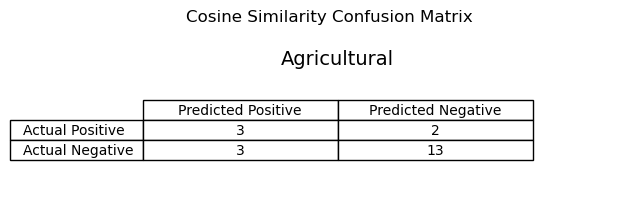

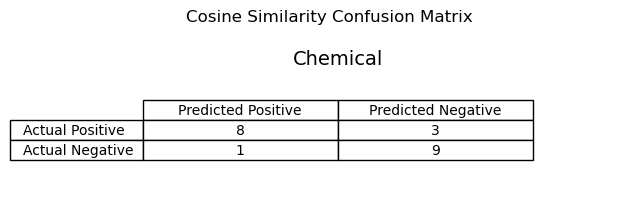

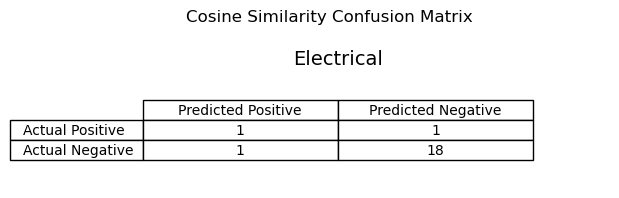

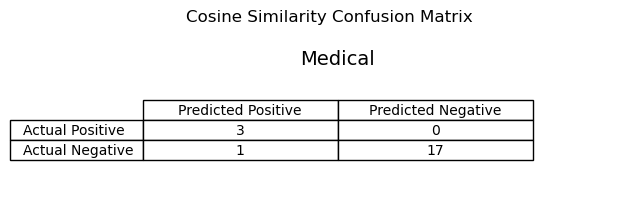

In [16]:
confusion_matrices = {}
index_labels = aggrgated_matching_label.index
for index_label in index_labels:
    TP = aggrgated_matching_label.loc[index_label, index_label]   
    FP = aggrgated_matching_label[index_label].sum() - TP    
    FN = aggrgated_matching_label.loc[index_label].sum() - TP    
    TN = aggrgated_matching_label.values.sum() - TP - FP - FN
    
    # Construct confusion matrix
    cm = pd.DataFrame([[TP, FP], [FN, TN]], columns=['Predicted Positive', 'Predicted Negative'], index=['Actual Positive', 'Actual Negative'])    
    # Store confusion matrix in the dictionary
    confusion_matrices[index_label] = cm

# Plot each confusion matrix and save as an image
for index_label, cm in confusion_matrices.items():
    fig, ax = plt.subplots(figsize=(7, 1.5))
    
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)
    
    table = pd.plotting.table(ax, cm, loc='center', cellLoc='center', colWidths=[0.3] * len(cm.columns))
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    
    plt.title(f'{index_label}', fontsize=14)
    plt.suptitle('Cosine Similarity Confusion Matrix',y=1.3)
    
    plt.savefig(f'table_{index_label}.png', bbox_inches='tight', dpi=300)
    
    plt.show()


In [17]:
metrics_df = pd.DataFrame(columns=['Precision', 'Recall', 'F1 Score'])
for index_label in index_labels:
    TP = aggrgated_matching_label.loc[index_label, index_label]  # True Positives (predicted and true label are the same)
    FP = aggrgated_matching_label[index_label].sum() - TP         # False Positives (predicted label is index_label, but true label is not)
    FN = aggrgated_matching_label.loc[index_label].sum() - TP     # False Negatives (true label is index_label, but predicted label is not)
    
    # Calculate precision, recall, and F1 score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics_df.loc[index_label] = [f"{precision * 100:.2f}%", f"{recall * 100:.2f}%", f"{f1 * 100:.2f}%"]

# Calculate average metrics
average_metrics = metrics_df.applymap(lambda x: float(x.rstrip('%'))).mean().to_frame().T
average_metrics = average_metrics.applymap(lambda x: f"{x:.2f}%")
average_metrics.index = ['Average']

metrics_df = pd.concat([metrics_df, average_metrics])

print(tabulate(metrics_df, headers='keys', tablefmt='pretty'))


+--------------+-----------+--------+----------+
|              | Precision | Recall | F1 Score |
+--------------+-----------+--------+----------+
| Agricultural |  60.00%   | 50.00% |  54.55%  |
|   Chemical   |  72.73%   | 88.89% |  80.00%  |
|  Electrical  |  50.00%   | 50.00% |  50.00%  |
|   Medical    |  100.00%  | 75.00% |  85.71%  |
|   Average    |  70.68%   | 65.97% |  67.56%  |
+--------------+-----------+--------+----------+


## Jaccard

In [18]:
# Jaccard
from sklearn.metrics import jaccard_score
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    try:
        return intersection / union
    except ZeroDivisionError:
        return None

most_similar_prd_for_dmd_df = pd.DataFrame({'dmd': tokenized_dmd_sample['dmd_urlIdentifier']})
most_similar_dmd_for_prd_df = pd.DataFrame({'prd': tokenized_prd_sample['prd_urlIdentifier']})

for c in ['title', 'description', 'key_words']:
    dmd_token = [set(tokens) for tokens in tokenized_dmd_sample['tokenized_dmd_' + str(c)]]
    prd_token = [set(tokens) for tokens in tokenized_prd_sample['tokenized_prd_' + str(c)]]

    similarity_matrix = np.zeros((len(dmd_token), len(prd_token)))

    for i, dmd_tokens in enumerate(dmd_token):
        for j, prd_tokens in enumerate(prd_token):
            similarity_matrix[i, j] = jaccard_similarity(dmd_tokens, prd_tokens)

    matching_results = pd.DataFrame(similarity_matrix , index=tokenized_dmd_sample[['dmd_label','dmd_urlIdentifier', ]], columns = tokenized_prd_sample[['prd_label','prd_urlIdentifier']])
    matching_label = pd.DataFrame(similarity_matrix , index=tokenized_dmd_sample['dmd_label'], columns=tokenized_prd_sample['prd_label']).applymap(lambda x: convert_value(x))

    if most_similar_result is None:
        most_similar_result = matching_results
    else:
        most_similar_result = pd.concat([most_similar_result, matching_results]).groupby(level=0).max()

    if most_similar_label is None:
        most_similar_label = matching_label
    else:
        most_similar_label = pd.concat([most_similar_label, matching_label]).groupby(level=0).max()

Text(158.22222222222223, 0.5, 'Demand (ID,Label)')

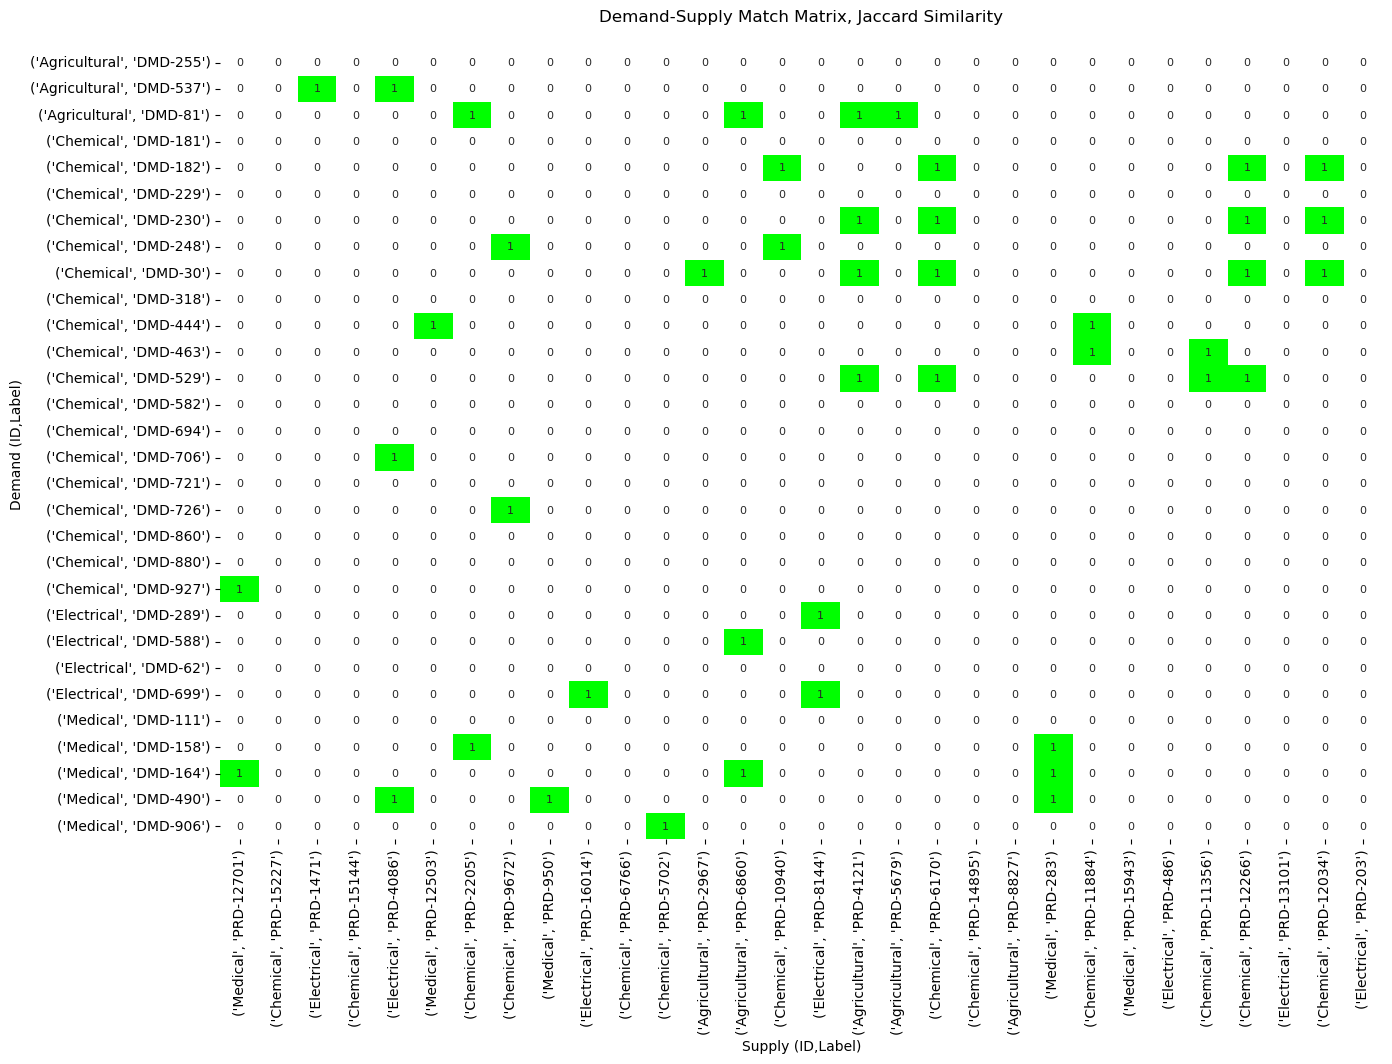

In [19]:
# plot 
plt.figure(figsize=(15,10))
plt.subplots_adjust(top=0.9)  # Adjust top margin
plt.subplots_adjust(right=0.9)
colors = [(1, 1, 1), (0, 1, 0)]  # Define white to green
cmap = mcolors.LinearSegmentedColormap.from_list("my_white_green_colormap", colors)
sns.heatmap(most_similar_result.applymap(lambda x: convert_value(x)), annot=True, fmt="d", cmap=cmap, annot_kws={"size": 8},cbar=False)
plt.title('Demand-Supply Match Matrix, Jaccard Similarity', pad=20)
plt.xlabel('Supply (ID,Label)')
plt.ylabel('Demand (ID,Label)')

In [20]:
from tabulate import tabulate
aggrgated_matching_label= matching_label.groupby(matching_label.index).sum().T.groupby(matching_label.columns).sum()
print(tabulate(aggrgated_matching_label, headers='keys', tablefmt='pretty'))

+--------------+--------------+----------+------------+---------+
|  prd_label   | Agricultural | Chemical | Electrical | Medical |
+--------------+--------------+----------+------------+---------+
| Agricultural |      2       |    3     |     1      |    0    |
|   Chemical   |      1       |    10    |     0      |    0    |
|  Electrical  |      2       |    0     |     1      |    0    |
|   Medical    |      0       |    1     |     0      |    3    |
+--------------+--------------+----------+------------+---------+


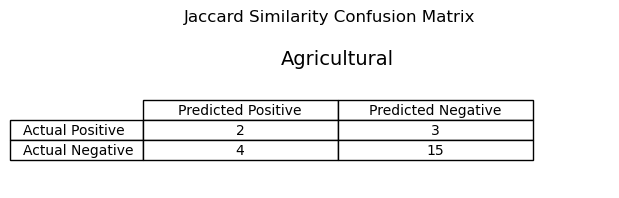

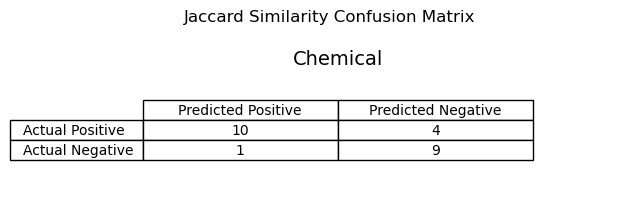

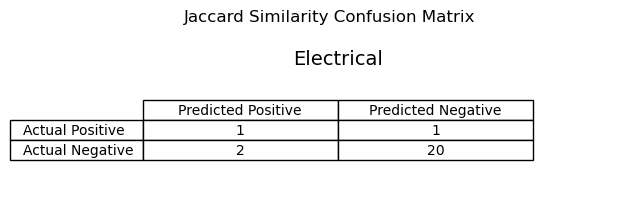

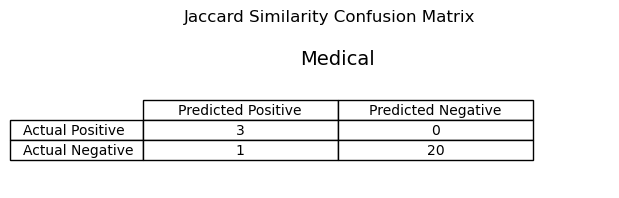

In [21]:
confusion_matrices = {}
index_labels = aggrgated_matching_label.index
for index_label in index_labels:
    TP = aggrgated_matching_label.loc[index_label, index_label]   
    FP = aggrgated_matching_label[index_label].sum() - TP    
    FN = aggrgated_matching_label.loc[index_label].sum() - TP    
    TN = aggrgated_matching_label.values.sum() - TP - FP - FN
    
    # Construct confusion matrix
    cm = pd.DataFrame([[TP, FP], [FN, TN]], columns=['Predicted Positive', 'Predicted Negative'], index=['Actual Positive', 'Actual Negative'])    
    # Store confusion matrix in the dictionary
    confusion_matrices[index_label] = cm

# Plot each confusion matrix and save as an image
for index_label, cm in confusion_matrices.items():
    fig, ax = plt.subplots(figsize=(7, 1.5))
    
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)
    
    table = pd.plotting.table(ax, cm, loc='center', cellLoc='center', colWidths=[0.3] * len(cm.columns))
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    
    plt.title(f'{index_label}', fontsize=14)
    plt.suptitle('Jaccard Similarity Confusion Matrix',y=1.3)
    
    plt.savefig(f'table_{index_label}.png', bbox_inches='tight', dpi=300)
    
    plt.show()


In [22]:
metrics_df = pd.DataFrame(columns=['Precision', 'Recall', 'F1 Score'])
for index_label in index_labels:
    TP = aggrgated_matching_label.loc[index_label, index_label]  # True Positives (predicted and true label are the same)
    FP = aggrgated_matching_label[index_label].sum() - TP         # False Positives (predicted label is index_label, but true label is not)
    FN = aggrgated_matching_label.loc[index_label].sum() - TP     # False Negatives (true label is index_label, but predicted label is not)
    
    # Calculate precision, recall, and F1 score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics_df.loc[index_label] = [f"{precision * 100:.2f}%", f"{recall * 100:.2f}%", f"{f1 * 100:.2f}%"]

# Calculate average metrics
average_metrics = metrics_df.applymap(lambda x: float(x.rstrip('%'))).mean().to_frame().T
average_metrics = average_metrics.applymap(lambda x: f"{x:.2f}%")
average_metrics.index = ['Average']

metrics_df = pd.concat([metrics_df, average_metrics])

print(tabulate(metrics_df, headers='keys', tablefmt='pretty'))


+--------------+-----------+--------+----------+
|              | Precision | Recall | F1 Score |
+--------------+-----------+--------+----------+
| Agricultural |  40.00%   | 33.33% |  36.36%  |
|   Chemical   |  71.43%   | 90.91% |  80.00%  |
|  Electrical  |  50.00%   | 33.33% |  40.00%  |
|   Medical    |  100.00%  | 75.00% |  85.71%  |
|   Average    |  65.36%   | 58.14% |  60.52%  |
+--------------+-----------+--------+----------+


## LDA

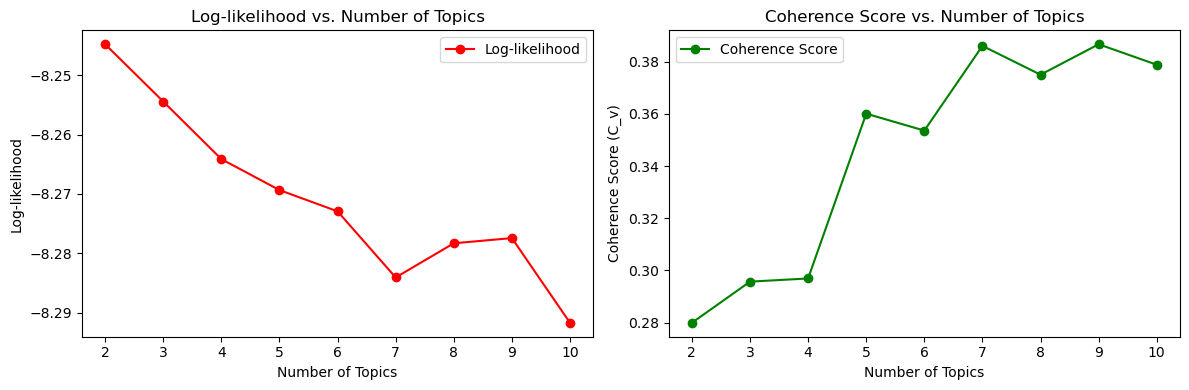

In [15]:
tokenized_prd_sampling = tokenized_prd_df.sample(n= 1000)
tokenized_documents = (tokenized_dmd_df['tokenized_dmd_title'] + tokenized_dmd_df['tokenized_dmd_description'] + tokenized_dmd_df['tokenized_dmd_key_words']).tolist() + (tokenized_prd_sampling['tokenized_prd_title'] + tokenized_prd_sampling['tokenized_prd_description'] + tokenized_prd_sampling['tokenized_prd_key_words']).tolist() 
dictionary = corpora.Dictionary(tokenized_documents)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]
num_topics_list = range(2, 11,1)  
perplexity_scores = []
log_likelihood_scores = []
coherence_scores = []

for num_topics in num_topics_list:
    lda_model = models.LdaModel(corpus,random_state=1234, num_topics=num_topics, id2word=dictionary, passes=5)
    
    perplexity = lda_model.log_perplexity(corpus)
    log_likelihood = lda_model.log_perplexity(corpus)
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    
    perplexity_scores.append(perplexity)
    log_likelihood_scores.append(log_likelihood)
    coherence_scores.append(coherence)

# Plot the evaluation metrics
plt.figure(figsize=(12, 4))

#Log-likelihood
plt.subplot(1, 2, 1)
plt.plot(num_topics_list, log_likelihood_scores, marker='o', linestyle='-', color='r', label='Log-likelihood')
plt.xlabel("Number of Topics")
plt.ylabel("Log-likelihood")
plt.title("Log-likelihood vs. Number of Topics")
plt.legend()

# Coherence Score
plt.subplot(1, 2, 2)
plt.plot(num_topics_list, coherence_scores, marker='o', linestyle='-', color='g', label='Coherence Score')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (C_v)")
plt.title("Coherence Score vs. Number of Topics")
plt.legend()

plt.tight_layout()

plt.show()

In [16]:
tokenized_dmd_df['sample'] = np.where(tokenized_dmd_df['dmd_urlIdentifier'].isin(tokenized_dmd_sample['dmd_urlIdentifier'].tolist()),1,0)
tokenized_prd_df['sample'] = np.where(tokenized_prd_df['prd_urlIdentifier'].isin(tokenized_prd_sample['prd_urlIdentifier'].tolist()),1,0)
x = len(tokenized_dmd_df)
y = len(tokenized_prd_df)

tokenized_documents = (tokenized_dmd_df['tokenized_dmd_title'] + tokenized_dmd_df['tokenized_dmd_description'] + tokenized_dmd_df['tokenized_dmd_key_words']).tolist() + (tokenized_prd_df['tokenized_prd_title'] + tokenized_prd_df['tokenized_prd_description'] + tokenized_prd_df['tokenized_prd_key_words'] ).tolist() 
dictionary = corpora.Dictionary(tokenized_documents)

corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]
lda_model = models.LdaModel(corpus,random_state=1234, num_topics=8, id2word=dictionary, passes=10)

topic_proportions = [lda_model[doc] for doc in corpus]

topic_labels = {}
for topic_id in range(lda_model.num_topics):
    topic_words = [word for word,
                    prob in lda_model.show_topic(topic_id)]
    topic_labels[topic_id] = ', '.join(topic_words)

document_labels = [max(topic_dist, key=lambda x: x[1])[0]
                    for topic_dist in topic_proportions]

labeled_documents = [topic_labels[label]
                        for label in document_labels]
topic_matrix = np.zeros((x, y), dtype=int)
# Fill the matrix
for i in range(x):
    for j in range(y):
        if labeled_documents[i] == labeled_documents[j + x]:
            topic_matrix[i, j] = 1
# Filter for sample
topic_matrix = topic_matrix[np.ix_(tokenized_dmd_df[tokenized_dmd_df['sample']==1].index,tokenized_prd_df[tokenized_prd_df['sample']==1].index)]
matching_results = pd.DataFrame(topic_matrix, index= tokenized_dmd_sample[['dmd_label','dmd_urlIdentifier']], columns=tokenized_prd_sample[['prd_label','prd_urlIdentifier']])
matching_label = pd.DataFrame(topic_matrix, index=tokenized_dmd_sample['dmd_label'], columns=tokenized_prd_sample['prd_label'])

In [20]:
np.unique(labeled_documents)

array(['آب, گاز, فشار, لوله, شیر, پتروشیم, پمپ, نف, انرژ, توربین',
       'خودرو, باز, رب, شبیه\u200cساز, موتور, حرک, باند, تابلو, تردد, پارکینگ',
       'دارو, ک, گیاه, پوس, بیمار, در, کود, سلول, اسید, رشد',
       'دما, تنظ, سنسور, دق, برق, موتور, تس, سرع, درجه, نیرو',
       'رنگ, نانو, مقاوم, آب, پوش, پل, لایه, بتن, پایه, پلیمر',
       'سیگنال, ابزار, حفار, چاه, کنتور, مانیتورینگ, آنتن, تس, کانال, سنج',
       'نرم\u200cافزار, مدیر, کاربر, شبکه, سرویس, ساز, افزار, برنامه, کار, ارسال',
       'چراغ, پزشک, لامپ, نور, پلاک, بیمار, LED, تخ, روشنا, جراح'],
      dtype='<U67')

Text(158.22222222222223, 0.5, 'Demand (ID,Label)')

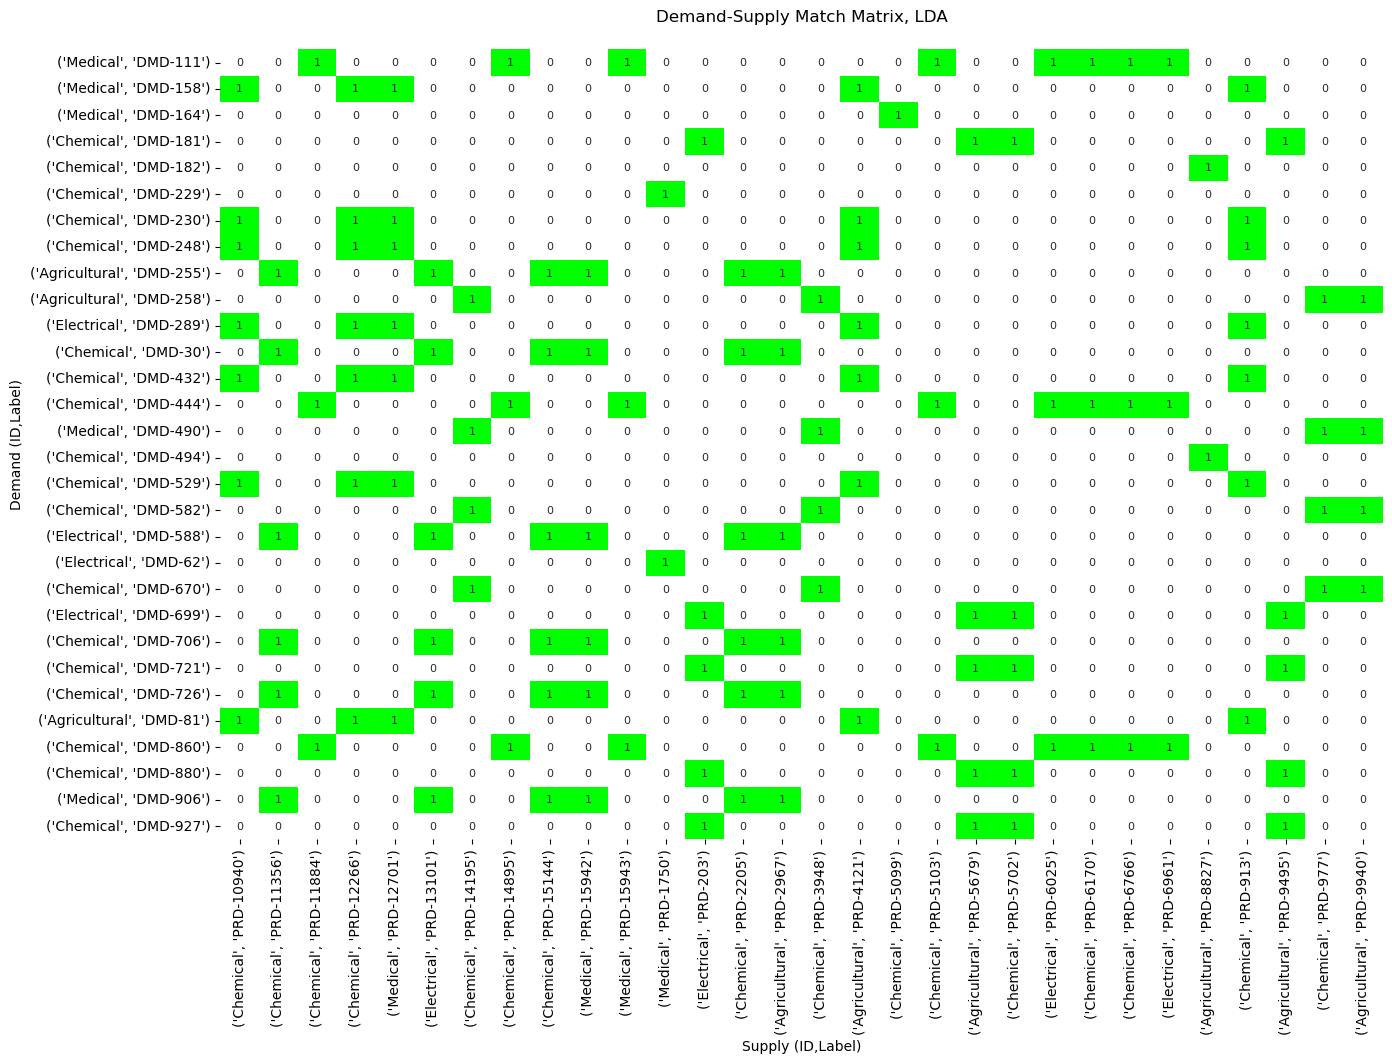

In [70]:
# plot 
plt.figure(figsize=(15,10))
plt.subplots_adjust(top=0.9)  # Adjust top margin
plt.subplots_adjust(right=0.9)
colors = [(1, 1, 1), (0, 1, 0)]  # Define white to green
cmap = mcolors.LinearSegmentedColormap.from_list("my_white_green_colormap", colors)
sns.heatmap(matching_results.applymap(lambda x: convert_value(x)), annot=True, fmt="d", cmap=cmap, annot_kws={"size": 8},cbar=False)
plt.title('Demand-Supply Match Matrix, LDA', pad=20)
plt.xlabel('Supply (ID,Label)')
plt.ylabel('Demand (ID,Label)')

In [72]:
from tabulate import tabulate
aggrgated_matching_label= matching_label.groupby(matching_label.index).sum().T.groupby(matching_label.columns).sum()
print(tabulate(aggrgated_matching_label, headers='keys', tablefmt='pretty'))

+--------------+--------------+----------+------------+---------+
|  prd_label   | Agricultural | Chemical | Electrical | Medical |
+--------------+--------------+----------+------------+---------+
| Agricultural |      3       |    19    |     4      |    3    |
|   Chemical   |      9       |    41    |     7      |   15    |
|  Electrical  |      1       |    11    |     2      |    3    |
|   Medical    |      2       |    10    |     3      |    3    |
+--------------+--------------+----------+------------+---------+


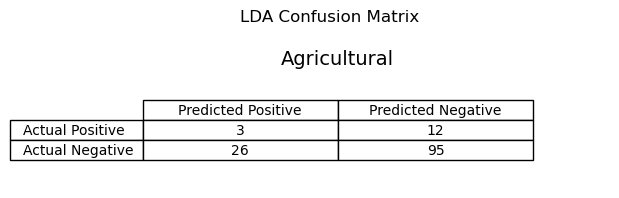

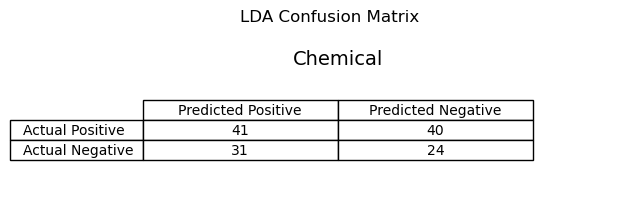

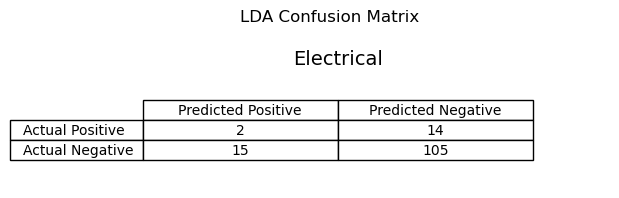

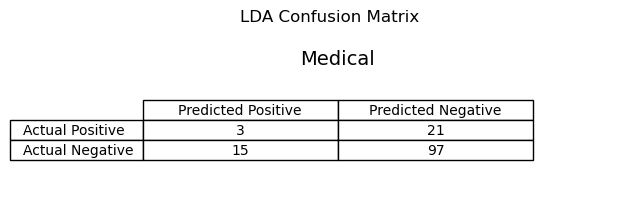

In [73]:
confusion_matrices = {}
index_labels = aggrgated_matching_label.index
for index_label in index_labels:
    TP = aggrgated_matching_label.loc[index_label, index_label]   
    FP = aggrgated_matching_label[index_label].sum() - TP    
    FN = aggrgated_matching_label.loc[index_label].sum() - TP    
    TN = aggrgated_matching_label.values.sum() - TP - FP - FN
    
    # Construct confusion matrix
    cm = pd.DataFrame([[TP, FP], [FN, TN]], columns=['Predicted Positive', 'Predicted Negative'], index=['Actual Positive', 'Actual Negative'])    
    # Store confusion matrix in the dictionary
    confusion_matrices[index_label] = cm

# Plot each confusion matrix and save as an image
for index_label, cm in confusion_matrices.items():
    fig, ax = plt.subplots(figsize=(7, 1.5))
    
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)
    
    table = pd.plotting.table(ax, cm, loc='center', cellLoc='center', colWidths=[0.3] * len(cm.columns))
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    
    plt.title(f'{index_label}', fontsize=14)
    plt.suptitle('LDA Confusion Matrix',y=1.3)
    
    plt.savefig(f'table_{index_label}.png', bbox_inches='tight', dpi=300)
    
    plt.show()

In [74]:
metrics_df = pd.DataFrame(columns=['Precision', 'Recall', 'F1 Score'])
for index_label in index_labels:
    TP = aggrgated_matching_label.loc[index_label, index_label]  # True Positives (predicted and true label are the same)
    FP = aggrgated_matching_label[index_label].sum() - TP         # False Positives (predicted label is index_label, but true label is not)
    FN = aggrgated_matching_label.loc[index_label].sum() - TP     # False Negatives (true label is index_label, but predicted label is not)
    
    # Calculate precision, recall, and F1 score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics_df.loc[index_label] = [f"{precision * 100:.2f}%", f"{recall * 100:.2f}%", f"{f1 * 100:.2f}%"]

# Calculate average metrics
average_metrics = metrics_df.applymap(lambda x: float(x.rstrip('%'))).mean().to_frame().T
average_metrics = average_metrics.applymap(lambda x: f"{x:.2f}%")
average_metrics.index = ['Average']

metrics_df = pd.concat([metrics_df, average_metrics])

print(tabulate(metrics_df, headers='keys', tablefmt='pretty'))


+--------------+-----------+--------+----------+
|              | Precision | Recall | F1 Score |
+--------------+-----------+--------+----------+
| Agricultural |  20.00%   | 10.34% |  13.64%  |
|   Chemical   |  50.62%   | 56.94% |  53.59%  |
|  Electrical  |  12.50%   | 11.76% |  12.12%  |
|   Medical    |  12.50%   | 16.67% |  14.29%  |
|   Average    |  23.91%   | 23.93% |  23.41%  |
+--------------+-----------+--------+----------+
